In [114]:
# install.packages("stargazer")
#install.packages("mvtnorm")
#install.packages("emmeans")

Installing package into ‘/home/angela/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Warning message:
“package ‘mvtnorm’ is not available (for R version 3.4.4)”Installing package into ‘/home/angela/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Warning message:
“dependency ‘mvtnorm’ is not available”Warning message in install.packages("emmeans"):
“installation of package ‘emmeans’ had non-zero exit status”

In [224]:
library("reshape2")
library("stargazer")
library("ggplot2")
#library("emmeans")

In [2]:
absPath = '/home/angela/padding_EBI/'

In [ ]:
file_scores <- "scores_final.csv"
file_accuracy <- "accu_final.csv"

### Defining functions

In [639]:
postproc_lm <- function(lm_res){
    sm <- summary(lm_res)
    sm_df <- as.data.frame(sm$coefficients)
    colnames(sm_df) <- c("Estimate", "Std.Error", "t.value", "p_val")
    sm_df["p_adjusted"] = p.adjust(sm_df$p_val, method = "fdr")
    index <- sm_df["p_adjusted"] >= 0.05
    #sm_df$Estimate[index] <- 0
    return(sm_df)
}

dividing_rownames <- function(group, df){
    names <- c()
    estimates <- c()
    pvals <- c()
    indices <- grep(group,rownames(df))
    subgroup <- rownames(df)[indices]
    for (i in 1:length(subgroup)){
        sg <- unlist(strsplit(subgroup[i], group)[1])[2]
        names <- c(names, sg)
        estimates <- c(estimates, df[subgroup[i], "Estimate"])
        pvals <- c(pvals, df[subgroup[i], "p_adjusted"])
              }
    mini_df <- data.frame("estimates"=estimates, "p_valor"=pvals)
    mini_df$significant <- mini_df["p_valor"] < 0.05
    rownames(mini_df) <- names
    mini_df[group] <- rownames(mini_df)
    mini_df["x"] <- 1
    return(mini_df)
}    

values_significant <- c("black", NA)
names(values_significant) <- c(TRUE, FALSE)

separating_interactions <- function(group1, group2, df){
    estimates_list <- c()
    xs <- c()
    ys <- c()
    interactions <- grep(":", rownames(df))
    df_int <- df[interactions,]
    df_esti <- df[-interactions,]
    pvals_list <- c()
    for (i in 1:length(rownames(df_int))){
        sg <- unlist(strsplit(rownames(df_int)[i], ":")[1])
        x <- unlist(strsplit(sg[1], group1)[1])[2]
        y <- unlist(strsplit(sg[2], group2)[1])[2]
        estimates_list <- c(estimates_list, df[rownames(df_int)[i], "Estimate"])
        pvals_list <- c(pvals_list, df_int[rownames(df_int)[i], "p_adjusted"])
        xs <- c(xs, x)
        ys <- c(ys, y)
        }
    interactions_df <- data.frame("estimates"=estimates_list, "x"=xs, "y"=ys, "p_val"=pvals_list)
    interactions_df$significant <- interactions_df$p_val < 0.05
    newList <- list("estimates_df"=df_esti, "interactions_df"=interactions_df)
    return(newList)

}

plotting_additive <- function(group, df){
    ggplot(df, aes_string( x="x", y=group)) +
geom_tile(aes(fill = estimates), colour = "white") + 
geom_tile(aes(color=significant), fill=NA, size=0.5) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11))+ 
coord_equal()
}

plotting_interactions <- function(df){
    ggplot(df$interactions_df, aes( x=x, y=y)) +
geom_tile(aes(fill = estimates), colour = "white") + 
geom_tile(aes(color=significant), fill=NA, size=0.5) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11),
     axis.text.x=element_text(size=10)) +
coord_equal()
    
}

# Task 1

In [6]:
task <- "task1/"

path_scores_task1 <- paste0(absPath, "data/results/", task, file_scores)
path_accu_task1 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task1 <- read.csv(file=path_scores_task1, header=TRUE, sep=",")
accu_task1 <- read.csv(file=path_accu_task1, header=TRUE, sep=",")

## Scores

In [510]:
scores_task1[0:5,]
scores_task1$X <- NULL
#filtering 
scores_task1 <- scores_task1[scores_task1$enz_type %in% c(0,1),]
sapply(scores_task1, class)
# habria que hacer un unmelt de variable-value
scores_task1_dcasted <- dcast(data = scores_task1,formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")
#tengo que cambiar el nombre de f1-score
colnames(scores_task1_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task1_dcasted[0:5,]

,enz_type,index,type_padding,architecture,variable,value
,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
1,0,0,post_padding,1_conv,f1-score,0.8548043
2,1,0,post_padding,1_conv,f1-score,0.8642715
6,0,0,pre_padding,1_conv,f1-score,0.8653776
7,1,0,pre_padding,1_conv,f1-score,0.8800000
11,0,0,mid_padding,1_conv,f1-score,0.8617318


enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
0,0,aug_padding,1_conv,0.7512593,0.6471795,0.8952308
0,0,aug_padding,bi_lstm,0.7167895,0.5736383,0.9551457
0,0,aug_padding,only_denses,0.8760426,0.8434343,0.9112736
0,0,aug_padding,stack_conv,0.7811460,0.6844007,0.9097457
0,0,ext_padding,1_conv,0.8403179,0.7971213,0.8884645


## changing reference

In [511]:
scores_task1_dcasted$architecture <- relevel(scores_task1_dcasted$architecture, "only_denses")
scores_task1_dcasted$type_padding <- relevel(scores_task1_dcasted$type_padding, "post_padding")

## defining "complete" lm task 1 (Additive)

In [512]:
lm_f1_task1_additive <- lm(f1_score~architecture+enz_type+type_padding, data=scores_task1_dcasted)

In [513]:
summary(lm_f1_task1_additive)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding, 
    data = scores_task1_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72626 -0.01819  0.00412  0.02333  0.09002 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.915552   0.006112 149.794  < 2e-16 ***
architecture1_conv       -0.063287   0.004990 -12.682  < 2e-16 ***
architecturebi_lstm      -0.143906   0.004990 -28.836  < 2e-16 ***
architecturestack_conv   -0.052351   0.004990 -10.490  < 2e-16 ***
enz_type1                 0.024232   0.003529   6.867 1.58e-11 ***
type_paddingaug_padding  -0.073154   0.007058 -10.365  < 2e-16 ***
type_paddingext_padding  -0.045384   0.007058  -6.431 2.52e-10 ***
type_paddingmid_padding   0.005152   0.007058   0.730   0.4657    
type_paddingpre_padding  -0.011706   0.007058  -1.659   0.0977 .  
type_paddingrnd_padding  -0.052515   0.007058  -7.441 3.30e-13 ***
type_paddingstrf_padding -0.010308   0.

In [514]:
sm1_df <- postproc_lm(lm_f1_task1_additive)
sm1_df

,Estimate,Std.Error,t.value,p_val,p_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.915552229,0.006112069,149.7941639,0.000000e+00,0.000000e+00
architecture1_conv,-0.063287318,0.004990483,-12.6816012,5.664933e-33,2.265973e-32
architecturebi_lstm,-0.143906274,0.004990483,-28.8361402,4.183409e-117,2.510045e-116
architecturestack_conv,-0.052350501,0.004990483,-10.4900665,7.837249e-24,2.351175e-23
enz_type1,0.024231756,0.003528805,6.8668457,1.580926e-11,2.710159e-11
type_paddingaug_padding,-0.073154146,0.007057609,-10.3652874,2.399845e-23,5.759629e-23
type_paddingext_padding,-0.045384439,0.007057609,-6.4305686,2.518908e-10,3.778362e-10
type_paddingmid_padding,0.005151980,0.007057609,0.7299895,4.656688e-01,4.656688e-01
type_paddingpre_padding,-0.011705948,0.007057609,-1.6586280,9.769011e-02,1.302535e-01


In [547]:
# Dividing lm in representable tiles
arch_df_1 <- dividing_rownames("architecture", sm1_df)
enz_df_1 <- dividing_rownames("enz_type", sm1_df)
pad_df_1 <- dividing_rownames("type_padding", sm1_df)

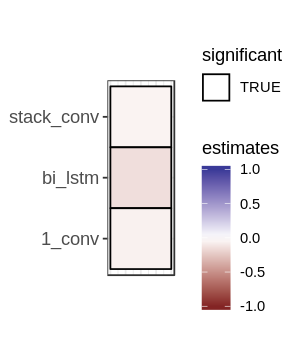

In [615]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("architecture", arch_df_1)

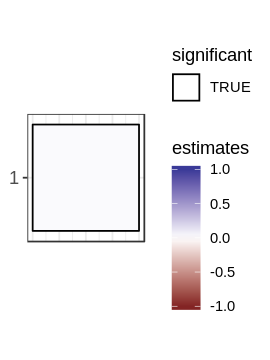

In [616]:
options(repr.plot.width=2.25, repr.plot.height=3)
plotting_additive("enz_type", enz_df_1)

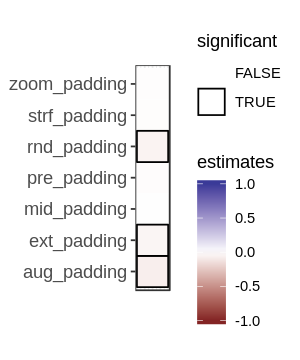

In [619]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_1)

## in SoA models, are dense paddings the same? 

In [520]:
soa_arch <- c("stack_conv", "bi_lstm")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task1_additive_soa <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch & type_padding %in% soa_pad))

In [521]:
summary(lm_f1_task1_additive_soa)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63387 -0.01356  0.00976  0.02012  0.09387 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                     0.776724   0.014281  54.387
architecturestack_conv                          0.080073   0.019042   4.205
enz_type1                                       0.044692   0.009521   4.694
type_paddingext_padding                        -0.142850   0.019042  -7.502
type_paddingmid_padding                         0.020414   0.019042   1.072
type_paddingpre_padding                        -0.014794   0.019042  -0.777
architecturestack_conv:type_paddingext_padding  0.138917   0.026929   5.159
architecturestack_conv:type_paddingmid_padding -0.025990   0.026929  -0

In [535]:
sm2_df <- postproc_lm(lm_f1_task1_additive_soa)
sm2_df_proc <- separating_interactions("architecture", "type_padding", sm2_df)

In [537]:
# Dividing lm in representable tiles
arch_df_2 <- dividing_rownames("architecture", sm2_df_proc$estimates_df)
enz_df_2 <- dividing_rownames("enz_type", sm2_df_proc$estimates_df)
pad_df_2 <- dividing_rownames("type_padding", sm2_df_proc$estimates_df)

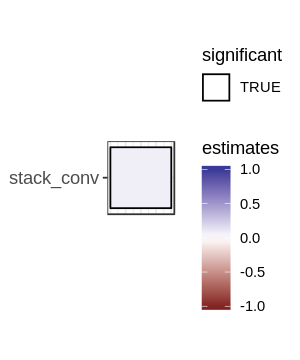

In [620]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("architecture", arch_df_2)

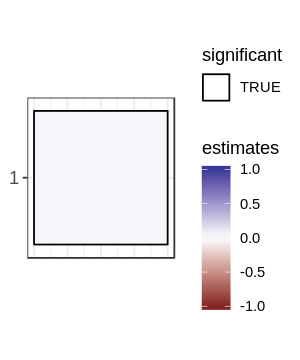

In [621]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("enz_type", enz_df_2)

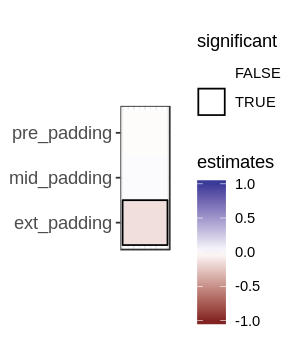

In [622]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_2)

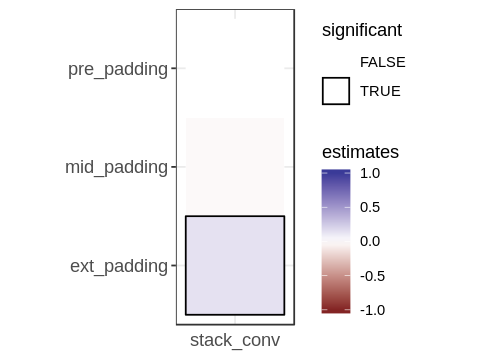

In [626]:
options(repr.plot.width=4, repr.plot.height=3)
plotting_interactions(sm2_df_proc)

## effect of sparse padding to state of the art architectures?

In [562]:
# interactions non significant
soa2_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task1_additive_soa3 <- lm(f1_score~architecture+enz_type+type_padding, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch & type_padding %in% soa2_pad))

In [565]:
summary(lm_f1_task1_additive_soa3)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding, 
    data = subset(scores_task1_dcasted, architecture %in% soa_arch & 
        type_padding %in% soa2_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.125632 -0.013578  0.002155  0.016052  0.049521 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.777703   0.004489 173.256  < 2e-16 ***
architecturestack_conv    0.075906   0.003665  20.711  < 2e-16 ***
enz_type1                 0.046901   0.003665  12.797  < 2e-16 ***
type_paddingrnd_padding  -0.059636   0.005183 -11.506  < 2e-16 ***
type_paddingstrf_padding -0.032954   0.005183  -6.358 2.21e-09 ***
type_paddingzoom_padding -0.010754   0.005183  -2.075   0.0397 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02318 on 154 degrees of freedom
Multiple R-squared:  0.8293,	Adjusted R-squared:  0.8238 
F-statistic: 149.6 on 5 and 154 DF,  p

In [568]:
sm3_df <- postproc_lm(lm_f1_task1_additive_soa3)

# Dividing lm in representable tiles
arch_df_3 <- dividing_rownames("architecture", sm3_df)
enz_df_3 <- dividing_rownames("enz_type", sm3_df)
pad_df_3 <- dividing_rownames("type_padding", sm3_df)

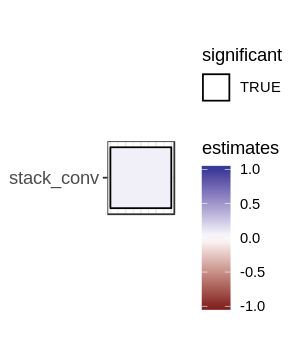

In [628]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("architecture", arch_df_3)

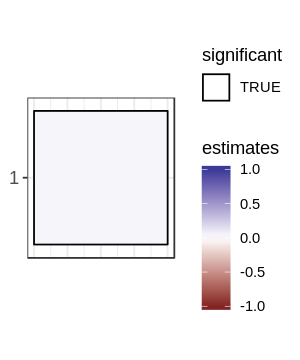

In [629]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("enz_type", enz_df_3)

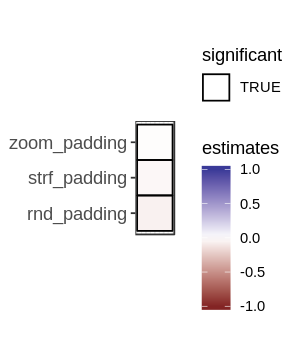

In [631]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_3)

## differences between types of padding?

In [574]:
lm_f1_task1_additive_soa4 <- lm(f1_score~enz_type+type_padding, 
                               data=subset(scores_task1_dcasted, architecture == "only_denses"))

In [575]:
summary(lm_f1_task1_additive_soa4)


Call:
lm(formula = f1_score ~ enz_type + type_padding, data = subset(scores_task1_dcasted, 
    architecture == "only_denses"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.075505 -0.008432  0.002578  0.010467  0.031178 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.8956930  0.0038765 231.057  < 2e-16 ***
enz_type1                 0.0087738  0.0025843   3.395 0.000877 ***
type_paddingaug_padding  -0.0001935  0.0051687  -0.037 0.970191    
type_paddingext_padding  -0.0041699  0.0051687  -0.807 0.421071    
type_paddingmid_padding   0.0105087  0.0051687   2.033 0.043789 *  
type_paddingpre_padding  -0.0008379  0.0051687  -0.162 0.871442    
type_paddingrnd_padding  -0.0041826  0.0051687  -0.809 0.419664    
type_paddingstrf_padding  0.0300487  0.0051687   5.814 3.51e-08 ***
type_paddingzoom_padding -0.0067748  0.0051687  -1.311 0.191932    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

In [579]:
sm4_df <- postproc_lm(lm_f1_task1_additive_soa4)

enz_df_4 <- dividing_rownames("enz_type", sm4_df)
pad_df_4 <- dividing_rownames("type_padding", sm4_df)

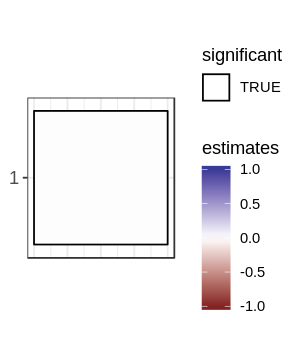

In [633]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("enz_type", enz_df_4)

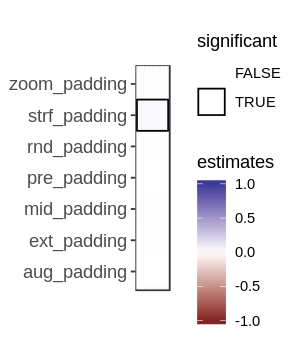

In [634]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_4)

## mejoran las capas convolucionales la performance de los modelos?

In [584]:
soa_pad <- c("post_padding", "strf_padding")
lm_f1_task1_soa5 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted, type_padding %in% soa_pad))

In [585]:
summary(lm_f1_task1_soa5)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted, 
    type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.133528 -0.009068 -0.000109  0.012975  0.037458 

Coefficients:
                                                 Estimate Std. Error t value
(Intercept)                                      0.886609   0.004840 183.167
architecture1_conv                              -0.027244   0.006454  -4.221
architecturebi_lstm                             -0.101010   0.006454 -15.651
architecturestack_conv                          -0.020937   0.006454  -3.244
enz_type1                                        0.026942   0.003227   8.349
type_paddingstrf_padding                         0.030049   0.006454   4.656
architecture1_conv:type_paddingstrf_padding     -0.035423   0.009127  -3.881
architecturebi_lstm:type_paddingstrf_padding    -0.068014   0.009127  -7.452
archi

In [586]:
sm5_df <- postproc_lm(lm_f1_task1_soa5)
sm5_df_proc <- separating_interactions("architecture", "type_padding", sm5_df)

In [587]:
# Dividing lm in representable tiles
arch_df_5 <- dividing_rownames("architecture", sm5_df_proc$estimates_df)
enz_df_5 <- dividing_rownames("enz_type", sm5_df_proc$estimates_df)
pad_df_5 <- dividing_rownames("type_padding", sm5_df_proc$estimates_df)

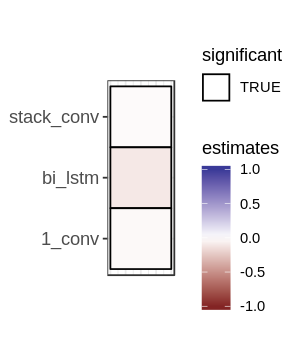

In [635]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("architecture", arch_df_5)

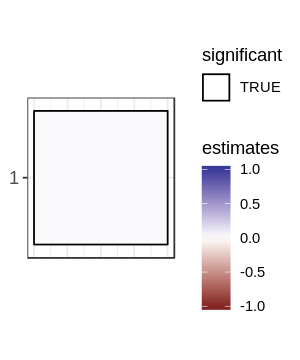

In [636]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("enz_type", enz_df_5)

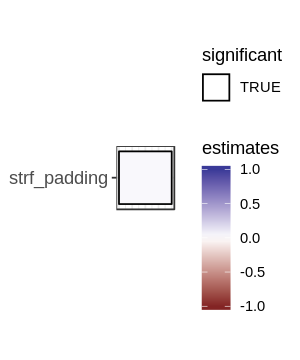

In [637]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_5)

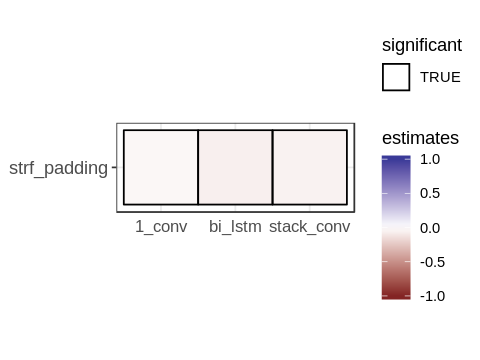

In [640]:
options(repr.plot.width=4, repr.plot.height=3)
plotting_interactions(sm5_df_proc)

## tiene aug_padding un buen efecto? 

In [601]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
scores_task1_dcasted_aug <- scores_task1_dcasted
scores_task1_dcasted_aug$type_padding <- relevel(scores_task1_dcasted_aug$type_padding, "aug_padding")
lm_f1_task1_soa6 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted_aug, type_padding %in% soa_pad))
summary(lm_f1_task1_soa6)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted_aug, 
    type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.173831 -0.012287  0.003771  0.013166  0.081870 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                      0.8939838  0.0071540 124.962
architecture1_conv                              -0.1438240  0.0097204 -14.796
architecturebi_lstm                             -0.1873464  0.0097204 -19.273
architecturestack_conv                          -0.1098636  0.0097204 -11.302
enz_type1                                        0.0118053  0.0039684   2.975
type_paddingpost_padding                         0.0001935  0.0097204   0.020
type_paddingstrf_padding                         0.0302421  0.0097204   3.111
architecture1_conv:type_paddingpost_padding      0.1165799  0.0137468 

In [602]:
sm6_df <- postproc_lm(lm_f1_task1_soa6)
sm6_df_proc <- separating_interactions("architecture", "type_padding", sm6_df)

In [603]:
# Dividing lm in representable tiles
arch_df_6 <- dividing_rownames("architecture", sm6_df_proc$estimates_df)
enz_df_6 <- dividing_rownames("enz_type", sm6_df_proc$estimates_df)
pad_df_6 <- dividing_rownames("type_padding", sm6_df_proc$estimates_df)

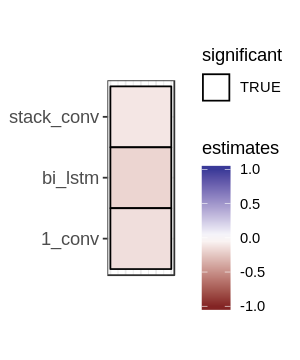

In [642]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("architecture", arch_df_6)

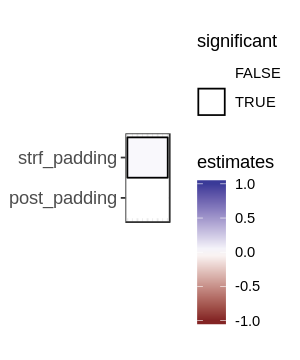

In [643]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("type_padding", pad_df_6)

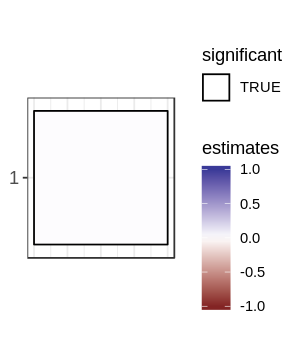

In [644]:
options(repr.plot.width=2.5, repr.plot.height=3)
plotting_additive("enz_type", enz_df_6)

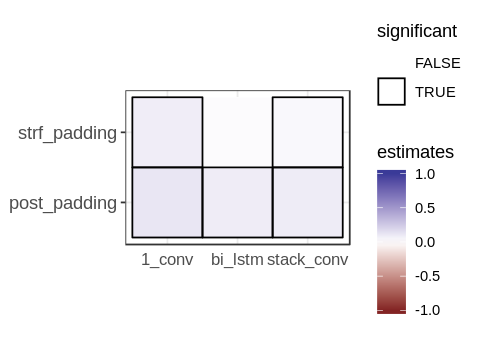

In [641]:
options(repr.plot.width=4, repr.plot.height=3)
plotting_interactions(sm6_df_proc)

# Task 2

In [166]:
task <- "task2/"

path_scores_task2 <- paste0(absPath, "data/results/", task, file_scores)
path_accu_task2 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task2 <- read.csv(file=path_scores_task2, header=TRUE, sep=",")
accu_task2 <- read.csv(file=path_accu_task2, header=TRUE, sep=",")

## Scores

In [167]:
scores_task2[0:5,]
dim(scores_task2)
scores_task2$X <- NULL

X,enz_type,index,type_padding,architecture,variable,value
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
0,1,0,post_padding,1_conv,f1-score,0.4609665
1,2,0,post_padding,1_conv,f1-score,0.6056475
2,3,0,post_padding,1_conv,f1-score,0.5493562
3,4,0,post_padding,1_conv,f1-score,0.4986877
4,5,0,post_padding,1_conv,f1-score,0.6060606


[1] 9600    7

In [168]:
#filtering 
scores_task2 <- scores_task2[scores_task2$enz_type %in% c(1,2,3,4,5,6,7),]
dim(scores_task2)
sapply(scores_task2, class)

[1] 6720    6

enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

In [169]:
# habria que hacer un unmelt de variable-value
scores_task2_dcasted <- dcast(data = scores_task2, formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")

In [170]:
#tengo que cambiar el nombre de f1-score
colnames(scores_task2_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task2_dcasted[0:5,]

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0,aug_padding,1_conv,0.4514306,0.4031546,0.51284109
1,0,aug_padding,bi_lstm,0.1046196,0.3407080,0.06179775
1,0,aug_padding,only_denses,0.4247295,0.3453997,0.55136437
1,0,aug_padding,stack_conv,0.4891587,0.5320755,0.45264848
1,0,ext_padding,1_conv,0.3833866,0.2678571,0.67415730


In [171]:
scores_task2_dcasted[0:5,]

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0,aug_padding,1_conv,0.4514306,0.4031546,0.51284109
1,0,aug_padding,bi_lstm,0.1046196,0.3407080,0.06179775
1,0,aug_padding,only_denses,0.4247295,0.3453997,0.55136437
1,0,aug_padding,stack_conv,0.4891587,0.5320755,0.45264848
1,0,ext_padding,1_conv,0.3833866,0.2678571,0.67415730


In [172]:
scores_task2_dcasted$architecture <- relevel(scores_task2_dcasted$architecture, "only_denses")
scores_task2_dcasted$type_padding <- relevel(scores_task2_dcasted$type_padding, "post_padding")

In [173]:
lm_f1_task2_additive <- lm(f1_score~architecture+enz_type+type_padding, 
                           data=scores_task2_dcasted)

In [174]:
summary(lm_f1_task2_additive)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding, 
    data = scores_task2_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51449 -0.05887 -0.00777  0.04113  0.40756 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.4422464  0.0090377  48.934  < 2e-16 ***
architecture1_conv        0.0206864  0.0061998   3.337 0.000862 ***
architecturebi_lstm      -0.4157025  0.0061998 -67.051  < 2e-16 ***
architecturestack_conv    0.0101555  0.0061998   1.638 0.101557    
enz_type2                 0.2559840  0.0082016  31.212  < 2e-16 ***
enz_type3                 0.0938845  0.0082016  11.447  < 2e-16 ***
enz_type4                 0.0039705  0.0082016   0.484 0.628352    
enz_type5                 0.1226206  0.0082016  14.951  < 2e-16 ***
enz_type6                 0.0426076  0.0082016   5.195 2.23e-07 ***
enz_type7                 0.0722387  0.0082016   8.808  < 2e-16 ***
type_paddingaug_padding  -0.

In [213]:
sm <- summary(lm_f1_task2_additive)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.4422464340,0.009037700,48.93351823,0.000000e+00
architecture1_conv,0.0206864331,0.006199811,3.33662334,8.619870e-04
architecturebi_lstm,-0.4157025061,0.006199811,-67.05083831,0.000000e+00
architecturestack_conv,0.0101554714,0.006199811,1.63802927,1.015571e-01
enz_type2,0.2559839638,0.008201579,31.21154769,1.157582e-177
enz_type3,0.0938845446,0.008201579,11.44713090,1.603864e-29
enz_type4,0.0039705100,0.008201579,0.48411533,6.283517e-01
enz_type5,0.1226205896,0.008201579,14.95085210,3.131778e-48
enz_type6,0.0426075747,0.008201579,5.19504554,2.233191e-07
enz_type7,0.0722386887,0.008201579,8.80790048,2.513275e-18


(Intercept)       architecture1_conv      architecturebi_lstm 
            0.000000e+00             1.628198e-03             0.000000e+00 
  architecturestack_conv                enz_type2                enz_type3 
            1.328055e-01            6.559630e-177             5.453139e-29 
               enz_type4                enz_type5                enz_type6 
            7.629985e-01             1.331006e-47             4.745532e-07 
               enz_type7  type_paddingaug_padding  type_paddingext_padding 
            7.120946e-18             1.130578e-01             9.681719e-01 
 type_paddingmid_padding  type_paddingpre_padding  type_paddingrnd_padding 
            1.763193e-02             9.681719e-01             5.203612e-16 
type_paddingstrf_padding type_paddingzoom_padding 
            9.833601e-01             1.852795e-03

In [175]:
soa_arch <- c("stack_conv", "bi_lstm")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task2_additive_soa <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture,
                               data=subset(scores_task2_dcasted, architecture %in% soa_arch &
                                          type_padding %in% soa_pad))
summary(lm_f1_task2_additive_soa)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20633 -0.06346 -0.01382  0.05131  0.36483 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                     0.020241   0.016375   1.236
architecturestack_conv                          0.443730   0.017505  25.349
enz_type2                                       0.344084   0.016375  21.013
enz_type3                                       0.109937   0.016375   6.714
enz_type4                                      -0.008815   0.016375  -0.538
enz_type5                                       0.065530   0.016375   4.002
enz_type6                                       0.057103   0.016375   3.487
enz_type7                                       0.059785   0.016375   3

In [214]:
sm <- summary(lm_f1_task2_additive_soa)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.020240849,0.01637454,1.2361168,2.169467e-01
architecturestack_conv,0.443729609,0.01750512,25.3485555,2.753774e-94
enz_type2,0.344083652,0.01637454,21.0133271,2.784364e-72
enz_type3,0.109936709,0.01637454,6.7138791,4.762129e-11
enz_type4,-0.008814513,0.01637454,-0.5383059,5.905853e-01
enz_type5,0.065530204,0.01637454,4.0019559,7.149597e-05
enz_type6,0.057103372,0.01637454,3.4873259,5.271776e-04
enz_type7,0.059784596,0.01637454,3.6510693,2.862712e-04
type_paddingext_padding,-0.030923912,0.01750512,-1.7665635,7.786005e-02
type_paddingmid_padding,0.042693956,0.01750512,2.4389405,1.504790e-02


(Intercept) 
                                  2.761139e-01 
                        architecturestack_conv 
                                  3.855284e-93 
                                     enz_type2 
                                  1.949055e-71 
                                     enz_type3 
                                  2.222327e-10 
                                     enz_type4 
                                  6.360149e-01 
                                     enz_type5 
                                  2.502359e-04 
                                     enz_type6 
                                  1.230081e-03 
                                     enz_type7 
                                  8.015594e-04 
                       type_paddingext_padding 
                                  1.362551e-01 
                       type_paddingmid_padding 
                                  3.009580e-02 
                       type_paddingpre_padding 
                                  6.803961e-01 
architecturestack_conv:type_paddingext_padding 
                                  5.645146e-01 
architecturestack_conv:type_paddingmid_padding 
                                  1.825322e-01 
architecturestack_conv:type_paddingpre_padding 
                                  2.369869e-01

In [182]:
soa_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task2_additive_soa2 <- lm(f1_score~architecture+enz_type+type_padding+type_padding*architecture,
                               data=subset(scores_task2_dcasted, architecture %in% soa_arch &
                                          type_padding %in% soa_pad))

In [183]:
summary(lm_f1_task2_additive_soa2)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding * architecture, data = subset(scores_task2_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40811 -0.04638 -0.00637  0.04437  0.37064 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                      0.0405106  0.0150445   2.693
architecturestack_conv                           0.4437296  0.0160832  27.590
enz_type2                                        0.3422050  0.0150445  22.746
enz_type3                                        0.0662313  0.0150445   4.402
enz_type4                                       -0.0078110  0.0150445  -0.519
enz_type5                                        0.0633978  0.0150445   4.214
enz_type6                                       -0.0003121  0.0150445  -0.021
enz_type7                                        0.02

In [215]:
sm <- summary(lm_f1_task2_additive_soa)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.020240849,0.01637454,1.2361168,2.169467e-01
architecturestack_conv,0.443729609,0.01750512,25.3485555,2.753774e-94
enz_type2,0.344083652,0.01637454,21.0133271,2.784364e-72
enz_type3,0.109936709,0.01637454,6.7138791,4.762129e-11
enz_type4,-0.008814513,0.01637454,-0.5383059,5.905853e-01
enz_type5,0.065530204,0.01637454,4.0019559,7.149597e-05
enz_type6,0.057103372,0.01637454,3.4873259,5.271776e-04
enz_type7,0.059784596,0.01637454,3.6510693,2.862712e-04
type_paddingext_padding,-0.030923912,0.01750512,-1.7665635,7.786005e-02
type_paddingmid_padding,0.042693956,0.01750512,2.4389405,1.504790e-02


(Intercept) 
                                  2.761139e-01 
                        architecturestack_conv 
                                  3.855284e-93 
                                     enz_type2 
                                  1.949055e-71 
                                     enz_type3 
                                  2.222327e-10 
                                     enz_type4 
                                  6.360149e-01 
                                     enz_type5 
                                  2.502359e-04 
                                     enz_type6 
                                  1.230081e-03 
                                     enz_type7 
                                  8.015594e-04 
                       type_paddingext_padding 
                                  1.362551e-01 
                       type_paddingmid_padding 
                                  3.009580e-02 
                       type_paddingpre_padding 
                                  6.803961e-01 
architecturestack_conv:type_paddingext_padding 
                                  5.645146e-01 
architecturestack_conv:type_paddingmid_padding 
                                  1.825322e-01 
architecturestack_conv:type_paddingpre_padding 
                                  2.369869e-01

In [185]:
lm_f1_task2_additive_soa3 <- lm(f1_score~enz_type+type_padding, 
                                data=subset(scores_task2_dcasted, architecture=="only_denses"))

summary(lm_f1_task2_additive_soa3 )


Call:
lm(formula = f1_score ~ enz_type + type_padding, data = subset(scores_task2_dcasted, 
    architecture == "only_denses"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49560 -0.03289  0.00192  0.03583  0.43419 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.43554    0.01546  28.170  < 2e-16 ***
enz_type2                 0.15236    0.01546   9.854  < 2e-16 ***
enz_type3                 0.10727    0.01546   6.938 1.13e-11 ***
enz_type4                 0.00524    0.01546   0.339 0.734809    
enz_type5                 0.16644    0.01546  10.765  < 2e-16 ***
enz_type6                 0.05805    0.01546   3.754 0.000192 ***
enz_type7                 0.02208    0.01546   1.428 0.153929    
type_paddingaug_padding   0.02269    0.01653   1.373 0.170354    
type_paddingext_padding   0.03393    0.01653   2.053 0.040543 *  
type_paddingmid_padding   0.03373    0.01653   2.041 0.041749 *  
type_paddingpre_padding   

In [218]:
sm <- summary(lm_f1_task2_additive_soa3)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.43553976,0.01546120,28.1698463,1.741656e-108
enz_type2,0.15235663,0.01546120,9.8541241,3.405529e-21
enz_type3,0.10726905,0.01546120,6.9379490,1.130344e-11
enz_type4,0.00523993,0.01546120,0.3389082,7.348091e-01
enz_type5,0.16644026,0.01546120,10.7650255,1.223724e-24
enz_type6,0.05804601,0.01546120,3.7543005,1.924697e-04
enz_type7,0.02207506,0.01546120,1.4277713,1.539294e-01
type_paddingaug_padding,0.02269191,0.01652872,1.3728774,1.703540e-01
type_paddingext_padding,0.03393440,0.01652872,2.0530565,4.054303e-02
type_paddingmid_padding,0.03373219,0.01652872,2.0408223,4.174890e-02


(Intercept)                enz_type2                enz_type3 
           2.438318e-107             1.589247e-20             3.956205e-11 
               enz_type4                enz_type5                enz_type6 
            7.348091e-01             8.566071e-24             5.389153e-04 
               enz_type7  type_paddingaug_padding  type_paddingext_padding 
            1.795843e-01             1.834582e-01             5.844846e-02 
 type_paddingmid_padding  type_paddingpre_padding  type_paddingrnd_padding 
            5.844846e-02             6.021547e-02             6.965330e-04 
type_paddingstrf_padding type_paddingzoom_padding 
            2.859513e-02             2.786129e-03

In [186]:
soa_pad <- c("post_padding", "strf_padding")
lm_f1_task2_soa4 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task2_dcasted, type_padding %in% soa_pad))
summary(lm_f1_task2_soa4)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted, 
    type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51926 -0.05773 -0.00332  0.04109  0.38064 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                      0.42715    0.01598  26.736
architecture1_conv                               0.04128    0.01708   2.417
architecturebi_lstm                             -0.39870    0.01708 -23.343
architecturestack_conv                           0.04503    0.01708   2.636
enz_type2                                        0.25161    0.01598  15.749
enz_type3                                        0.09749    0.01598   6.102
enz_type4                                       -0.01585    0.01598  -0.992
enz_type5                                        0.10563    0.01598   6.612
enz_type6               

In [220]:
sm <- summary(lm_f1_task2_soa4)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.42714847,0.01597669,26.7357282,2.710379e-101
architecture1_conv,0.04128025,0.01707980,2.4169046,1.597987e-02
architecturebi_lstm,-0.39869932,0.01707980,-23.3433233,4.170817e-84
architecturestack_conv,0.04503029,0.01707980,2.6364642,8.615936e-03
enz_type2,0.25161494,0.01597669,15.7488769,2.413403e-46
enz_type3,0.09748874,0.01597669,6.1019357,1.987196e-09
enz_type4,-0.01584517,0.01597669,-0.9917679,3.217501e-01
enz_type5,0.10563108,0.01597669,6.6115744,9.067041e-11
enz_type6,0.03916583,0.01597669,2.4514354,1.454107e-02
enz_type7,0.09211050,0.01597669,5.7653050,1.364747e-08


(Intercept) 
                                  3.794531e-100 
                             architecture1_conv 
                                   2.237182e-02 
                            architecturebi_lstm 
                                   2.919572e-83 
                         architecturestack_conv 
                                   1.507789e-02 
                                      enz_type2 
                                   1.126255e-45 
                                      enz_type3 
                                   5.564147e-09 
                                      enz_type4 
                                   3.217501e-01 
                                      enz_type5 
                                   3.173464e-10 
                                      enz_type6 
                                   2.237182e-02 
                                      enz_type7 
                                   3.184410e-08 
                       type_paddingstrf_padding 
                                   2.560453e-02 
    architecture1_conv:type_paddingstrf_padding 
                                   1.108538e-01 
   architecturebi_lstm:type_paddingstrf_padding 
                                   4.619202e-03 
architecturestack_conv:type_paddingstrf_padding 
                                   6.341953e-02

In [193]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
scores_task2_dcasted_aug <- scores_task2_dcasted
scores_task2_dcasted_aug$type_padding <- relevel(scores_task2_dcasted_aug$type_padding, "aug_padding")
lm_f1_task2_soa5 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task2_dcasted_aug, type_padding %in% soa_pad))
summary(lm_f1_task2_soa5)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted_aug, 
    type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51669 -0.05483 -0.00686  0.03844  0.38321 

Coefficients:
                                                 Estimate Std. Error t value
(Intercept)                                      0.450800   0.014164  31.827
architecture1_conv                               0.004791   0.016355   0.293
architecturebi_lstm                             -0.442202   0.016355 -27.037
architecturestack_conv                          -0.027212   0.016355  -1.664
enz_type2                                        0.252614   0.012492  20.223
enz_type3                                        0.087289   0.012492   6.988
enz_type4                                       -0.001736   0.012492  -0.139
enz_type5                                        0.111277   0.012492   8.908
enz_type6  

In [222]:
sm <- summary(lm_f1_task2_soa5)
sm$coefficients
p.adjust(sm$coefficients[,4], method = "fdr")

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.450799865,0.01416422,31.8266548,1.726186e-145
architecture1_conv,0.004790672,0.01635544,0.2929101,7.696648e-01
architecturebi_lstm,-0.442201638,0.01635544,-27.0369810,1.118016e-115
architecturestack_conv,-0.027212264,0.01635544,-1.6638054,9.653248e-02
enz_type2,0.252613582,0.01249167,20.2225607,4.034840e-74
enz_type3,0.087289177,0.01249167,6.9877901,5.772940e-12
enz_type4,-0.001735849,0.01249167,-0.1389605,8.895154e-01
enz_type5,0.111276659,0.01249167,8.9080681,3.289375e-18
enz_type6,0.025423426,0.01249167,2.0352301,4.214806e-02
enz_type7,0.088582561,0.01249167,7.0913298,2.864575e-12


(Intercept) 
                                  3.107134e-144 
                             architecture1_conv 
                                   8.658729e-01 
                            architecturebi_lstm 
                                  1.006215e-114 
                         architecturestack_conv 
                                   1.737585e-01 
                                      enz_type2 
                                   2.420904e-73 
                                      enz_type3 
                                   1.731882e-11 
                                      enz_type4 
                                   8.979523e-01 
                                      enz_type5 
                                   1.480219e-17 
                                      enz_type6 
                                   9.483313e-02 
                                      enz_type7 
                                   1.031247e-11 
                       type_paddingpost_padding 
                                   2.485332e-01 
                       type_paddingstrf_padding 
                                   3.546063e-01 
    architecture1_conv:type_paddingpost_padding 
                                   1.882581e-01 
   architecturebi_lstm:type_paddingpost_padding 
                                   1.207136e-01 
architecturestack_conv:type_paddingpost_padding 
                                   4.759563e-03 
    architecture1_conv:type_paddingstrf_padding 
                                   8.979523e-01 
   architecturebi_lstm:type_paddingstrf_padding 
                                   2.608369e-01 
architecturestack_conv:type_paddingstrf_padding 
                                   3.438063e-01

## Accuracy

In [73]:
accu_task2[0:5,]

X,index,variable,value,architecture
<int>,<int>,<fct>,<dbl>,<fct>
0,0,post_padding,0.5472170,1_conv
1,1,post_padding,0.5284553,1_conv
2,2,post_padding,0.5121951,1_conv
3,3,post_padding,0.5247029,1_conv
4,4,post_padding,0.5247029,1_conv


In [81]:
#filtering 
sapply(accu_task2, class)

index     variable        value architecture 
   "integer"     "factor"    "numeric"     "factor"

In [82]:
#cambio el nombre a las columnas
colnames(accu_task2) <- c("index", "type_padding", "accuracy", "architecture")
accu_task2[0:5,]

index,type_padding,accuracy,architecture
<int>,<fct>,<dbl>,<fct>
0,post_padding,0.5472170,1_conv
1,post_padding,0.5284553,1_conv
2,post_padding,0.5121951,1_conv
3,post_padding,0.5247029,1_conv
4,post_padding,0.5247029,1_conv


In [91]:
lm_accu_task2 <- lm(accuracy~architecture+type_padding+ type_padding:architecture, data=accu_task2)

In [92]:
summary(lm_accu_task2)


Call:
lm(formula = accuracy ~ architecture + type_padding + type_padding:architecture, 
    data = accu_task2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058286 -0.006551  0.000000  0.008456  0.043340 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                       0.547923   0.004672 117.279
architecturebi_lstm                              -0.185580   0.006607 -28.088
architectureonly_denses                          -0.012088   0.006607  -1.830
architecturestack_conv                           -0.021379   0.006607  -3.236
type_paddingext_padding                          -0.009086   0.006607  -1.375
type_paddingmid_padding                          -0.009086   0.006607  -1.375
type_paddingpost_padding                         -0.017716   0.006607  -2.681
type_paddingpre_padding                          -0.015528   0.006607  -2.350
type_paddingrnd_padding                          -0.09276

## Construyendo tablas

In [107]:
stargazer(lm_acc_task1,lm_accu_task2, title="Linear models on F1 score", align=TRUE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, Oct 30, 2019 - 12:29:50 PM
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{Linear models on F1 score} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} D{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{2}{c}{\textit{Dependent variable:}} \\ 
\cline{2-3} 
\\[-1.8ex] & \multicolumn{2}{c}{accuracy} \\ 
\\[-1.8ex] & \multicolumn{1}{c}{(1)} & \multicolumn{1}{c}{(2)}\\ 
\hline \\[-1.8ex] 
 architecturebi\_lstm & -0.040^{***} & -0.186^{***} \\ 
  & (0.009) & (0.007) \\ 
  & & \\ 
 architectureonly\_denses & 0.143^{***} & -0.012^{*} \\ 
  & (0.009) & (0.007) \\ 
  & & \\ 
 architecturestack\_conv & 0.033^{***} & -0.021^{***} \\ 
  & (0.009) & (0.007) \\ 
  & & \\ 
 type\_paddingext\_padding & 0.085^{***} & -0.009 \\ 
  & (0.009) & (0.007) \\ 
  & & \\ 
 type\_paddingmid\_padding & 0.110^{***} & -0.009 \\

In [109]:
stargazer(lm_f1_task1,lm_f1_task2, title="Linear models on F1 score", align=TRUE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, Oct 30, 2019 - 12:30:37 PM
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{Linear models on F1 score} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} D{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{2}{c}{\textit{Dependent variable:}} \\ 
\cline{2-3} 
\\[-1.8ex] & \multicolumn{2}{c}{f1\_score} \\ 
\\[-1.8ex] & \multicolumn{1}{c}{(1)} & \multicolumn{1}{c}{(2)}\\ 
\hline \\[-1.8ex] 
 architecturebi\_lstm & -0.081^{***} & -0.436^{***} \\ 
  & (0.005) & (0.006) \\ 
  & & \\ 
 architectureonly\_denses & 0.063^{***} & -0.021^{***} \\ 
  & (0.005) & (0.006) \\ 
  & & \\ 
 architecturestack\_conv & 0.011^{**} & -0.011^{*} \\ 
  & (0.005) & (0.006) \\ 
  & & \\ 
 enz\_type1 & 0.024^{***} &  \\ 
  & (0.004) &  \\ 
  & & \\ 
 enz\_type2 &  & 0.256^{***} \\ 
  &  & (0.008) \\ 
  & & \\ 
 enz\_type3 &  & 0